In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

torch.manual_seed(1)
np.random.seed(1)

In [2]:
class Model(nn.Module):
    def __init__(self, features):
        super().__init__()
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        self.fc4 = nn.Linear(features, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1)

In [3]:
noise = 0.1

X_train, y_train = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

num_classes = 2
batch_size = 64

def train_model(max_epochs):
    model = Model(20)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

    def step(engine, batch):
        model.train()
        optimizer.zero_grad()

        x, y = batch

        y_pred = model(x)
        loss =  F.nll_loss(y_pred, y)

        loss.backward()
        optimizer.step()

        return loss.item()

    def eval_step(engine, batch):
        model.eval()

        x, y = batch
        y_pred = model(x)

        return y_pred, y


    trainer = Engine(step)
    evaluator = Engine(eval_step)

    metric = Accuracy()
    metric.attach(evaluator, "accuracy")

    metric = Loss(F.nll_loss)
    metric.attach(evaluator, "nll")

    ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

    ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
    dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_results(trainer):
        evaluator.run(dl_test)
        metrics = evaluator.state.metrics

        print(f"Test Results - Epoch: {trainer.state.epoch} Acc: {metrics['accuracy']:.4f} NLL: {metrics['nll']:.2f}")
    
    trainer.run(dl_train, max_epochs=max_epochs)
    
    return model

In [4]:
ensemble = 5
models = [train_model(50) for _ in range(ensemble)]

Test Results - Epoch: 1 Acc: 0.7350 NLL: 0.68
Test Results - Epoch: 2 Acc: 0.7250 NLL: 0.64
Test Results - Epoch: 3 Acc: 0.8250 NLL: 0.58
Test Results - Epoch: 4 Acc: 0.8300 NLL: 0.50
Test Results - Epoch: 5 Acc: 0.8300 NLL: 0.43
Test Results - Epoch: 6 Acc: 0.8500 NLL: 0.37
Test Results - Epoch: 7 Acc: 0.8650 NLL: 0.33
Test Results - Epoch: 8 Acc: 0.8700 NLL: 0.30
Test Results - Epoch: 9 Acc: 0.8800 NLL: 0.28
Test Results - Epoch: 10 Acc: 0.8800 NLL: 0.26
Test Results - Epoch: 11 Acc: 0.8750 NLL: 0.25
Test Results - Epoch: 12 Acc: 0.8900 NLL: 0.24
Test Results - Epoch: 13 Acc: 0.8850 NLL: 0.24
Test Results - Epoch: 14 Acc: 0.8750 NLL: 0.23
Test Results - Epoch: 15 Acc: 0.8950 NLL: 0.23
Test Results - Epoch: 16 Acc: 0.8800 NLL: 0.23
Test Results - Epoch: 17 Acc: 0.9100 NLL: 0.22
Test Results - Epoch: 18 Acc: 0.8850 NLL: 0.21
Test Results - Epoch: 19 Acc: 0.8850 NLL: 0.20
Test Results - Epoch: 20 Acc: 0.8850 NLL: 0.20
Test Results - Epoch: 21 Acc: 0.8850 NLL: 0.19
Test Results - Epoch: 

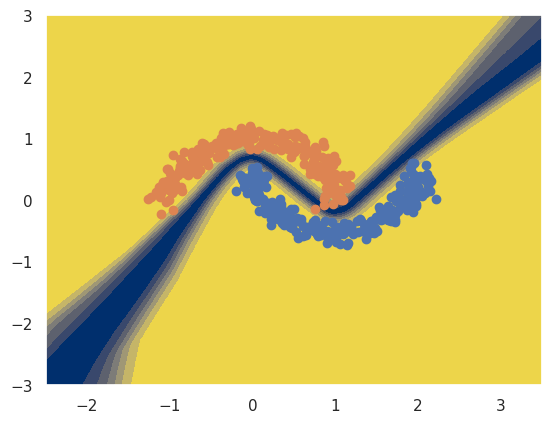

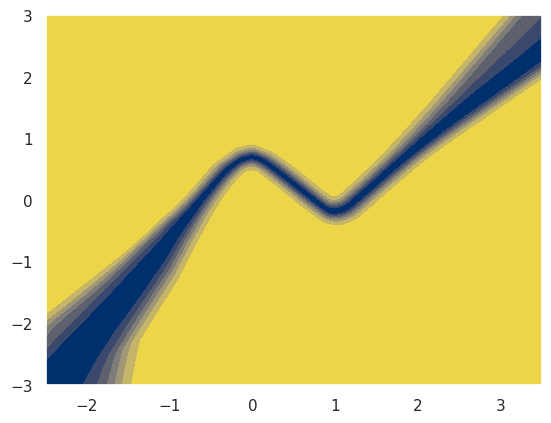

In [6]:
domain = 3
x = np.linspace(-domain+0.5, domain+0.5, 100)
y = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x, y)

X = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(bool)

for model in models:
    model.eval()

with torch.no_grad():
    predictions = torch.stack([model(torch.from_numpy(X).float()) for model in models])

    mean_prediction = torch.mean(predictions.exp(), dim=0)
    confidence = torch.sum(mean_prediction * torch.log(mean_prediction), dim=1)

z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x, y, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

plt.figure()
plt.contourf(x, y, z, cmap='cividis')